In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino
## Session 06 - Ensemble Learning

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import sys
import os
from time import time
import numpy as np
import pandas as pd


import matplotlib

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')


TEST_SIZE = 0.25

<Figure size 1500x900 with 0 Axes>


### Load Dataset

In [4]:
digits = load_digits()

print(digits.keys())

X_train, X_test, y_train, y_test = train_test_split ( digits.data,     digits.target, 
                                                     stratify=digits.target, 
                                                     random_state=RANDOM_STATE)

X_train.shape

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


(1347, 64)

In [5]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

Decision Trees are Perfect... almost. There is one aspect that prevents them from being the ideal model for predictive learning, namely **Inaccuracy**
<img src='../../images/ml/random_forest.png' width= 500 alt='Random Forest'>

## Random Forests

One problem with decision trees is that they can end up **over-fitting** the data. They are such flexible models that, given a large depth, they can quickly memorize the inputs, which doesn't generalize well to previously unseen data. One way to get around this is to use many slightly different decision trees in concert. This is known as **Random Forests**, and is one of the more common techniques of **ensemble learning** (i.e. combining the results from several estimators.

<img src = '../../images/ensamble.png' alt='Ensamble and Random forest' width = 800/>

Random Forest is widely used for both classification and regression tasks. It is a powerful and versatile method that combines the predictions of multiple decision trees to make more accurate and robust predictions.

- **Decision Trees**: Random Forest is based on the concept of decision trees. Decision trees are tree-like structures that partition the input data into smaller subsets based on a set of rules or conditions. Each leaf node in the tree represents a prediction.

- **Ensemble of Trees**: Random Forest builds a large number of decision trees, typically hundreds or even thousands, by using a process called bootstrapping. Bootstrapping involves randomly selecting subsets of the training data with replacement. Each decision tree is trained on one of these bootstrapped datasets.

- **Feature Randomness**: In addition to bootstrapping, Random Forest introduces another level of randomness by considering only a random subset of features when making decisions at each node in each tree. This helps to ensure that the individual trees in the forest are diverse and not overly correlated.

- **Voting or Averaging**: Once all the trees in the Random Forest have been trained, they are used to make predictions. In the case of classification, each tree "votes" for a class, and the class with the most votes becomes the final prediction. In the case of regression, the predictions from all the trees are averaged to obtain the final prediction.

### Advantages:

- **High Accuracy**: Random Forest typically provides higher accuracy compared to individual decision trees because it reduces the risk of overfitting and takes advantage of the wisdom of crowds by aggregating the predictions from multiple trees.

- **Robustness**: The diversity of the individual trees makes Random Forest robust to noisy or uninformative features and less sensitive to outliers in the data.

- **Reduced Overfitting**: Random Forest is less prone to overfitting compared to a single decision tree, thanks to its ensemble nature and the use of bootstrapping and feature randomness.

- **Handles High-Dimensional Data**: Random Forest can handle datasets with a large number of features or attributes, making it suitable for a wide range of applications.

- **Variable Importance**: It can also provide a measure of feature importance, which can help in feature selection and understanding the most influential features in the data.

## Random Forest Process
- **Step 1:** - Create a boot strapped data which is of same size as original. We can pick the same observation more than once.
- **Step 2:** - Create a decision tree using bootstrapped data but only use a random subset of features at each step. Build the complete tree but only considering random subset of features.
- **Step 3:** Keep iterating Steps 1 and 2 and make '100s' of trees.
- Random selection results in wise variety of trees.

<img src='../../images/ml/random_forest_2.png' alt='Random forest 2'>

### How do we use it?
1. Pick data and run it through the trees and get the results.
2. Conclude whatever results get maximum results

Bootstrapping of data and using the aggregates (max votes) is called Bagging.

How do we know its right one?

**Out-of-Bag dataset:** When we created boot strapped data, a proportion of data never made it to any of the bootstrapped set. We use this data to verify.

Measurement of Random Forest is 'proportion of out-of-bag sample correctly labeled'.

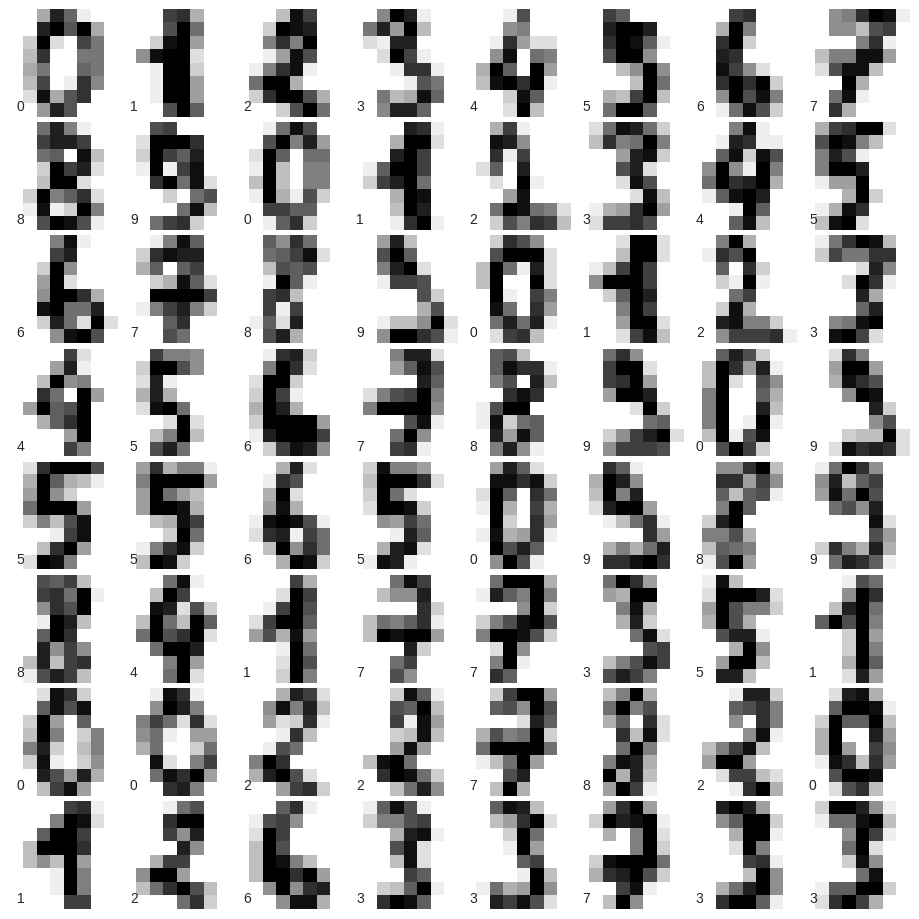

In [17]:
# set up the figure
fig = plt.figure(figsize=(9, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

RF: max_depth =   3 | F1 Score :  0.8959
RF: max_depth =   5 | F1 Score :  0.9461
RF: max_depth =  10 | F1 Score :  0.9687


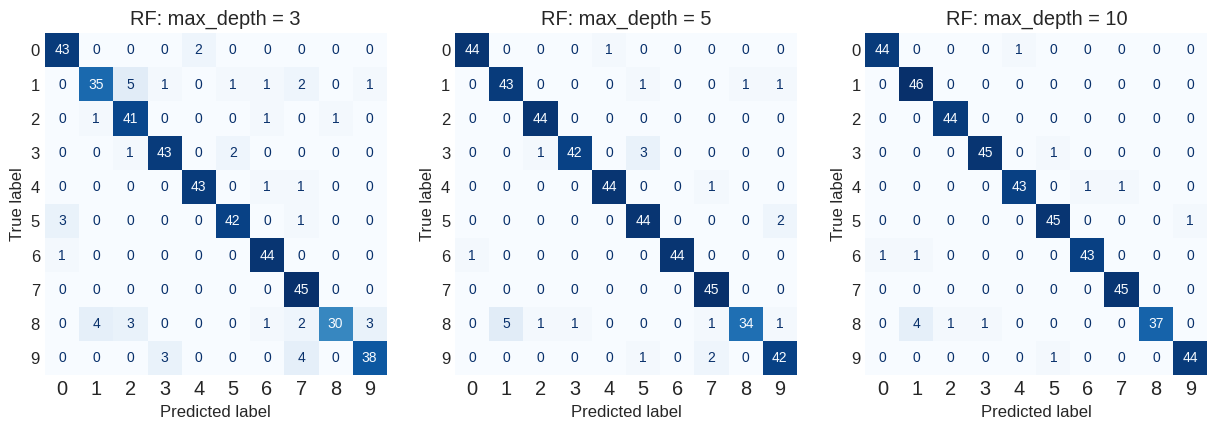

In [7]:
# random forest results
fig, axes = plt.subplots(1,3, figsize = (15,8))

for i, max_depth in enumerate([3, 5, 10]):
    
    clf = RandomForestClassifier(max_depth=max_depth).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print("RF: max_depth = {:3d}".format(max_depth), end = ' | ')
    
    print("F1 Score : {: .4f}".format(f1_score(y_test, y_pred, average='weighted')))
    
    cm = confusion_matrix(y_test, y_pred)

    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

    disp.plot(ax = axes[i], cmap=plt.cm.Blues, colorbar=False);
    
    axes[i].set_title("RF: max_depth = {0}".format(max_depth))
    
    axes[i].grid()

## Grid Search

In [8]:
params = {
    'n_estimators': [100, 200, 500], # number of trees
    'max_depth': [None, 10, 25, 50], # The maximum depth of the tree.
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2], # The minimum number of samples required to be at a leaf node.
    'max_features' : ['sqrt', 'log2', None]
}

rf_clf = RandomForestClassifier()

clf = RandomizedSearchCV(estimator=rf_clf,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

print("Best Accuracy: ", clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Best Accuracy:  0.9740134930469504


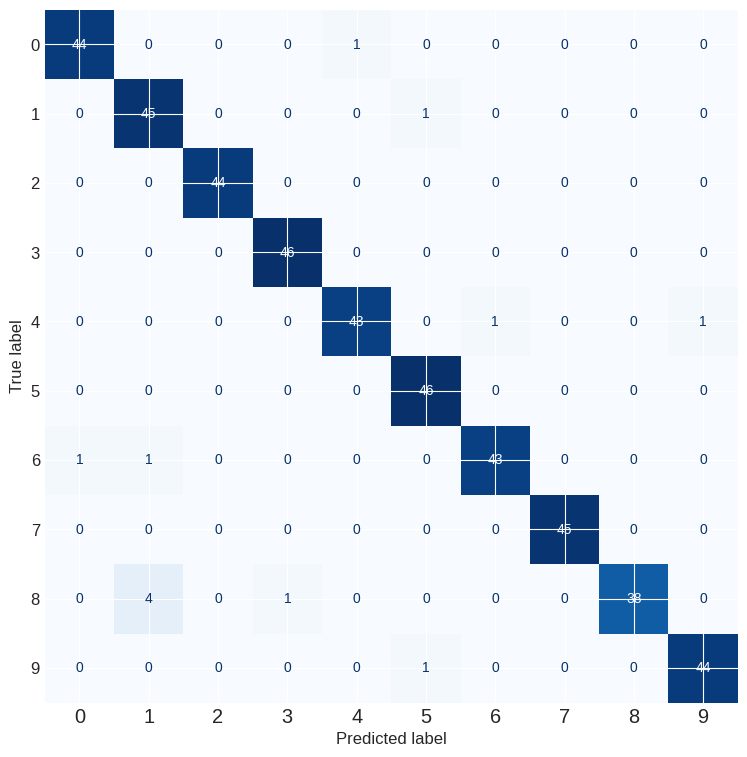

In [9]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

disp.plot( cmap=plt.cm.Blues, colorbar=False);



## AdaBoost

### Idea
3 main ideas are:
1. AdaBoost combines lot of weak learners to make classification.
2. Some stumps get more say in classification than others.
3. Each stump is made by taking previous stump's mistakes into account.

### Steps:
- **Step 1:** Each observation is weighed equal for first decision stump.
- **Step 2:** Mis-classified observations are assigned more weights in proportion of mistakes made. 
- **Step 3:** New stumps are drawn considering observations with higher weights as more significant.
- **Step 4:** Again mis-classified observations are given higher weights.

Process is continued till we get minimum error.

### Comparison
|#|Random Forest|AdaBoost|
|:-:|:--|:--|
|1.|Construct complete tree with random observation and using a number of features.|Decision stumps - with root node and two leaves.Hence, we make a forest of stumps.Stumps are just using one variable to make a decision.|
|2.| Each tree has equal say in the decision.|Some stumps have more say in final decision than others.|
|3.|Each tree is constructed independently of the others. Trees can be constructed in any order.|In AdaBoost, order is important. Error any stump makes influences how next stump will be constructed.|


## XGBoost (Extreme Gradient Boosting)
It belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library.

### Boosting

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

<img src='../../images/boosting_fig1.png' width = '800px' alt='Boosting' />

**Classifier 1**: The first classifier (usually a decision stump) creates a split. It says anything within pink area is $x$ and anything outside is $\checkmark$. However, this classifier mis-classifies three $x$ points.

*Note: a Decision Stump is a Decision Tree model that only splits off at one level, therefore the final prediction is based on only one feature.*

**Classifier 2**: The second classifier gives more weight to the **three $x$ misclassified points** and creates another split. Again it says, anything within pink area is $x$ and anything outside is $\checkmark$. Still, it too is wrong in classifying three $\checkmark$ points.

**Classifier 2**: Again, the third classifier gives more weight to the three $\checkmark$ misclassified points and creates yet another area. This classifier too fails to classify the points (in purple circles) correctly.

**Overall**: This is a weighted combination of the weak classifiers (Classifiers 1,2 and 3). It does a good job at classifying all the points correctly.

In [10]:
# Scaling is important for XGBoost 

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Training

In [11]:
clf = xgb.XGBClassifier(tree_method = "hist", 
                        random_state=RANDOM_STATE)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=24, ...)

In [12]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.9533333333333334


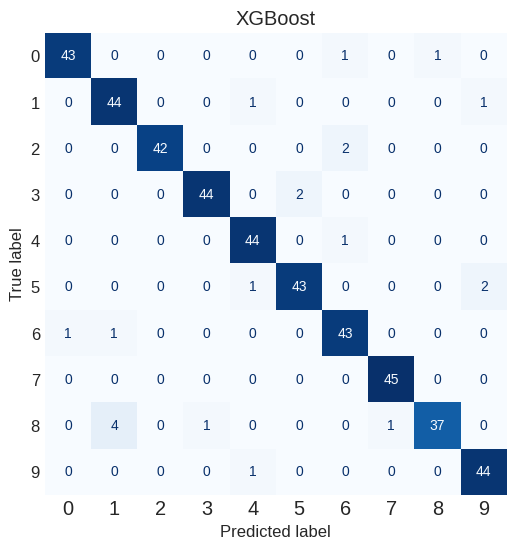

In [13]:
fig, ax = plt.subplots(figsize = (6,6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);
ax.set_title("XGBoost")
ax.grid()
plt.show()

## Randomized Search

In [14]:
xg_clf = xgb.XGBClassifier(tree_method = "hist",
                           random_state=RANDOM_STATE, 
                           verbosity = 1)

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000]}


clf = RandomizedSearchCV(estimator=xg_clf,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

print("Best Accuracy: ", clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6}
Best Accuracy:  0.9732755059892606


In [15]:
# Some helpers to format the plot

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.9733333333333334


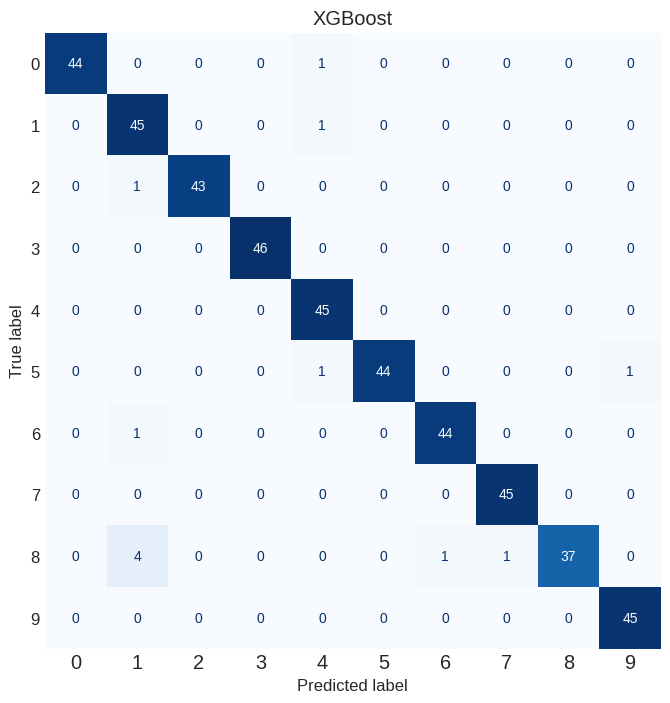

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);
ax.set_title("XGBoost")
ax.grid()
plt.show()

## Assignment
https://www.kaggle.com/competitions/santander-customer-satisfaction/overview